In [1]:
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u

%matplotlib inline 

import matplotlib.pyplot as plt
from matplotlib import rcParams

import pandas as pd

In [2]:
rcParams.update({'font.size': 22,'figure.figsize':[12,8]})

## Setup the defaults for the run you want to analyze

In [3]:
# User updates the following four lines
run_id = 'gamma-2-base-0' # Robostrategy run_id
reassign_name = None  # If different from run_id, this is the rootname that preceeds '_final_obs.csv' e.g. beta-5-reverse
more_calibs = True    # Did the simulation use the new, larger set of reserved resources for calibrators?
run_dir = f'{run_id}/'  # Another popular option might simply be './'


#User should not have to update the remaining lines
if reassign_name is None:
    obs_new = pd.read_csv(f'{run_dir}{run_id}_final_obs.csv')
    out_root=run_id
else:
    obs_new = pd.read_csv(f'{run_dir}{reassign_name}_final_obs.csv')
    out_root=run_id
    
if more_calibs: # True for gamma-2 and beyond and select gamma-0 runs
    apogee_fibers = 300 - 50 
    robots = 500 - 60 
else:  # Less calibs for all beta- runs and select gamma-0 runs
    apogee_fibers = 300 - 10 
    robots = 500 - 20 

   
    

In [4]:
#This code loops through fields and calculates rough positions and fiber usage
ufield=np.unique(obs_new['field_id'])[1:] # cuts off -1

f_avg_ra = []
f_avg_dec = []
f_all_lun = []
f_nepoch = []
f_nexposure = []
f_apogee_slots = []
f_all_slots = []
f_apogee_used_slots = []
f_all_used_slots = []

for onefield in ufield:
    sub_set = obs_new[obs_new.field_id == onefield]
    
    f_avg_ra.append(np.mean(sub_set.ra))
    f_avg_dec.append(np.mean(sub_set.dec))
    f_nepoch.append(sub_set.field_epochs.values[0])
    f_nexposure.append(sub_set.field_exposures.values[0])

    
    f_all_lun.append(sub_set.field_lun.values[0])

    fepochs = sub_set.field_epochs.values[0]
    fexposures = sub_set.field_exposures.values[0]
    
    f_apogee_slots.append(fepochs * fexposures * apogee_fibers)
    f_all_slots.append(fepochs * fexposures * robots)
    
    f_all_used_slots.append(np.sum(sub_set.slots_used))

    apogee_subset = sub_set[sub_set.instr == 'a']
    f_apogee_used_slots.append(np.sum(apogee_subset.slots_used)) 


input_data = {'ra': f_avg_ra, 'dec': f_avg_dec, 'slots_apogee': f_apogee_slots,
             'slots_robots': f_all_slots, 'used_apogee': f_apogee_used_slots, 
             'used_robots': f_all_used_slots, 'lun': f_all_lun, 'nepoch': f_nepoch,
             'nexposure': f_nexposure}


field_table = pd.DataFrame(input_data)



In [5]:
def plot_field_usage(ftab,apogee_only=False,lunation='all',save=None,galactic=False):
    
    if lunation not in ['all','bright','dark']:
        raise ValueError('Lunation can only be "all", "bright", or "dark"')
        
    if lunation == 'dark':
        plt_tab = ftab[ftab.lun == 0.35]
        title = 'Dark Fields'
    elif lunation == 'bright':
        plt_tab = ftab[ftab.lun == 1.0]
        title = 'Bright Fields'
    else:
        plt_tab = ftab
        title = 'All Fields'
        
    if apogee_only:
        c_ratio = plt_tab['used_apogee']/plt_tab['slots_apogee']
        c_title = 'Fraction of APOGEE Resources Used'
    else:
        c_ratio = plt_tab['used_robots']/plt_tab['slots_robots']
        c_title = 'Fraction of Robot Resources Used'
        
    # Create markersize array to account for different size of fields
    dot_size = np.ones_like(plt_tab)* 3
    dot_size[plt_tab['dec'] > -13] *= (1.5/0.8)**2 # NSDIV is -14, but give an extra degree 
    '''Pulling from APOGEE-2 Targeting paper that maximum radii of APO/LCO are 1.5/0.95 but that for
    LCO Typical max due to vignetting is 0.8'''
    
    # Decide on coordinates
    if galactic:
        ra = plt_tab['ra']
        dec = plt_tab['dec']
        coord_fk5 = SkyCoord(ra,dec,unit=(u.deg,u.deg),frame="fk5")
        coord_gal = coord_fk5.transform_to(frame="galactic")
        x = coord_gal.l.radian
        x[x>np.pi] -= np.pi*2
        y = coord_gal.b.radian
    else:
        x = np.deg2rad(plt_tab['ra'])
        x[x> np.pi] -= 2*np.pi
        y = np.deg2rad(plt_tab['dec'])
        
    plt.subplot(111, projection='aitoff')
    plt.grid(True)
    plt.scatter(x,y, c=c_ratio,s=dot_size,cmap='nipy_spectral')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(c_title)
    if save is not None:
        plt.savefig(save)



## Example 1
Plot the robot resource utilization of all fields (bright & dark fields) in Galactic coordinates

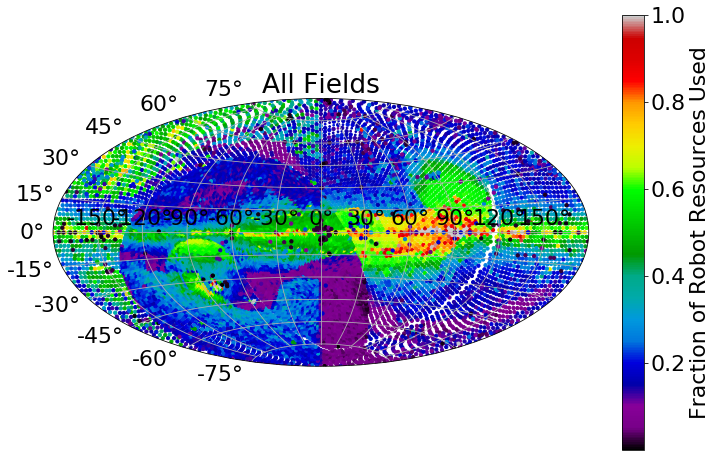

In [6]:
plot_field_usage(field_table, apogee_only=False,lunation='all',galactic=True,
                 save=f'{run_dir}robot_resource_{out_root}_allfield.pdf')

## Example 2:
Plot the APOGEE fiber utilization of only the bright fields in Equatorial coordinates.

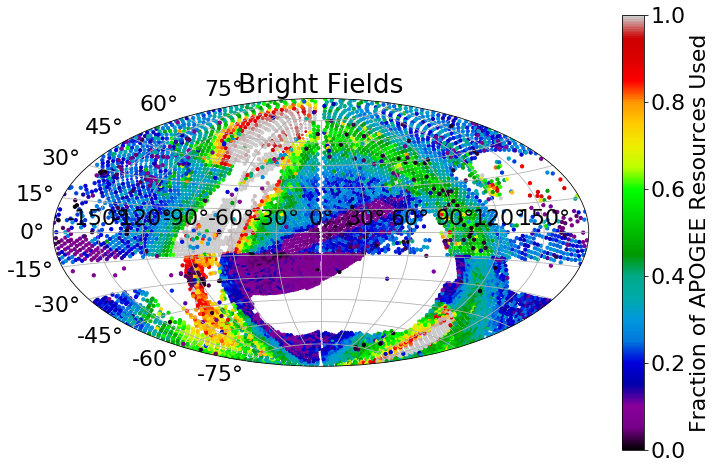

In [7]:
plot_field_usage(field_table, apogee_only=True,lunation='bright',galactic=False,
                 save=f'{run_dir}robot_resource_{out_root}_apogee_bright.pdf')